## 00 . Import packages

In [55]:
%matplotlib inline

In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import pandas_profiling as prof

from sklearn.ensemble import RandomForestClassifier as rfc
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

## 01 . Import data

I converted the raw rdata file into a pipe-separated text file for python. The rdata files is combined form of all files in train folder, containing raw measurements and their transforamtions.

To get test data, we'll have to combine files in test folder in a simialr fashion. If anyone comes across a difference in these datasets, lets discuss that before moving forward.

In [2]:
randomState = 42
ntree=25

In [3]:
data = pd.read_csv('../data/samsungData.txt',sep='|')

In [4]:
train = data.sample(frac=0.7,
                    random_state=randomState)

test = data[~data.index.isin(train.index)]

## 02 . Profiling

data_profile = prof.ProfileReport(data)

data_profile.to_file('../data_profile.html')

## 03.a. Base RF - with all variables

In [5]:
def varPlot(X,model):
    
    model_vars = pd.DataFrame(
         {'variable':X.columns,
          'importance':model.feature_importances_})

    model_vars.sort_values(by='importance',
                           ascending=False,
                           inplace=True)
    
    sns.plt.figure(figsize=(15,6))
    sns.set_style('whitegrid')

    sns.barplot(y='importance',
        x='variable',
        data=model_vars,
        palette=sns.color_palette("Blues_r",
                                  n_colors=X.shape[1]))
    sns.plt.xticks(rotation=90)
    sns.plt.xlabel('Variable')
    sns.plt.ylabel('Variable Importance')
    sns.plt.title('Random Forest : Averaged variable importance over '+str(ntree)+' trees')

In [11]:
X = train[train.columns[:-2]]
Y = train.activity
randomState = 42

model0 = rfc(n_estimators=ntree,
             random_state=randomState,
             n_jobs=4,
             warm_start=True,
             oob_score=True)
model0 = model0.fit(X, Y)
model0.oob_score_

0.96502137582588421

In [24]:
varPlot(X=X,model=model0)

In [25]:
model_vars0 = pd.DataFrame(
         {'variable':X.columns,
          'importance':model0.feature_importances_})

model_vars0.sort_values(by='importance',
                           ascending=False,
                           inplace=True)

## 03.b. top n variables

In [26]:
n = 25

cols_model = [col for col in model_vars0.variable[:n].values]

In [27]:
oobAccuracy = {}

for cols in range(n):
    X = train[[col for col in model_vars0['variable'][:cols+1].values]]
    Y = train.activity
    
    model1 = rfc(n_estimators=ntree,
                 random_state=randomState,
                 n_jobs=4,
                 warm_start=False,
                 oob_score=True)
    
    model1 = model1.fit(X, Y)
    accuracy = accuracy_score(Y,model1.predict(X))
    
    oobAccuracy[cols+1] = [cols+1,model1.oob_score_,accuracy]

accuracyTable =pd.DataFrame.from_dict(oobAccuracy).transpose()
accuracyTable.columns = ['variables','oobAccuracy','accuracy']

In [28]:
sns.plt.figure(figsize=(10,5))
sns.plt.scatter(x=accuracyTable.variables,
                y=100*accuracyTable.oobAccuracy)

sns.plt.xlim(0,n+1)
sns.plt.ylim(0,100)
sns.plt.minorticks_on()

sns.plt.xlabel('Number of variables')
sns.plt.ylabel('Accuracy(%)')
sns.plt.title('OOB Accuracy vs Number of variables')

In [29]:
varPlot(X,model1)

## 03.c. selected variables (5) from top 15

In [30]:
n_used = 4

cols_model = [col for col in model_vars0.variable[:n_used].values] + [model_vars0.variable[12]]

In [31]:
X = train[cols_model]
Y = train.activity

In [92]:
ntree_determination = {}

for ntree in range(5,150,5):
    model = rfc(n_estimators=ntree,
             random_state=randomState,
             n_jobs=4,
             warm_start=False,
             oob_score=True)
    model = model.fit(X, Y)
    ntree_determination[ntree]=model.oob_score_

### Determining number of trees : oob accuracy vs number of trees

In [93]:
ntree_determination = pd.DataFrame.from_dict(ntree_determination,orient='index')
ntree_determination['ntree'] = ntree_determination.index
ntree_determination.columns=['oobScore','ntree']

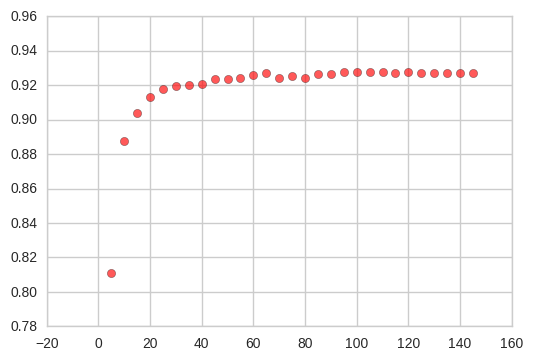

In [114]:
sns.plt.figure(figsize=(6,4),)

sns.plt.scatter(x='ntree',y='oobScore',
                s=35,c='red',alpha=0.65,
                data=ntree_determination)

In [115]:
model2 = rfc(n_estimators=25,
             random_state=randomState,
             n_jobs=4,
             warm_start=False,
             oob_score=True)
model2 = model2.fit(X, Y)

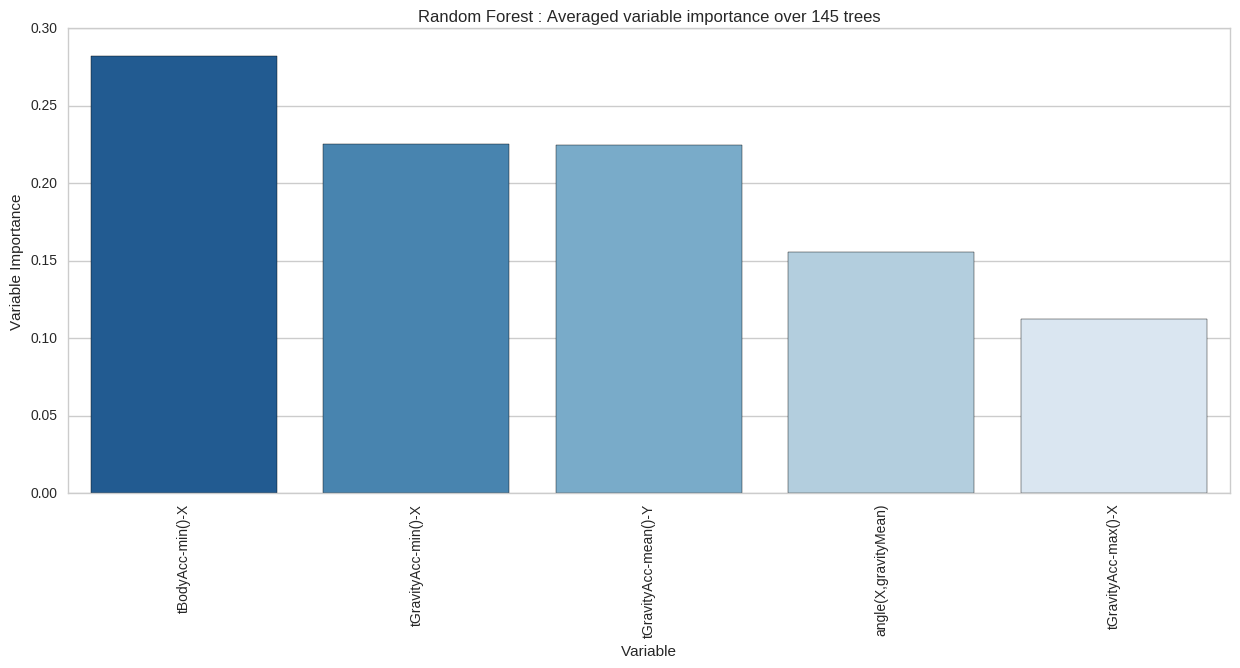

In [116]:
varPlot(X,model2)

In [117]:
train_actual = Y
train_pred = model2.predict(X)

In [118]:
confusion_matrix(train_actual,train_pred)

array([[984,   0,   0,   0,   0,   0],
       [  0, 903,   1,   0,   0,   0],
       [  0,   0, 966,   0,   0,   0],
       [  0,   0,   0, 847,   0,   0],
       [  0,   0,   0,   0, 708,   0],
       [  0,   0,   0,   0,   0, 737]])

In [119]:
accuracy_score(train_actual,train_pred)

0.99980567431014378

In [120]:
model2.oob_score_

0.91799455888068404

## 4. Test set results

In [121]:
test_actual = test.activity
test_pred = model2.predict(test[X.columns])

In [122]:
confusion_matrix(test_actual,test_pred)

array([[423,   0,   0,   0,   0,   0],
       [  0, 362,  19,   0,   0,   1],
       [  0,  25, 381,   1,   0,   1],
       [  0,   0,   0, 343,  20,  16],
       [  0,   0,   0,  19, 225,  34],
       [  0,   0,   0,  17,  10, 309]])

In [123]:
accuracy_score(test_actual,test_pred)

0.92611060743427021

### Distribution of final variables for each category

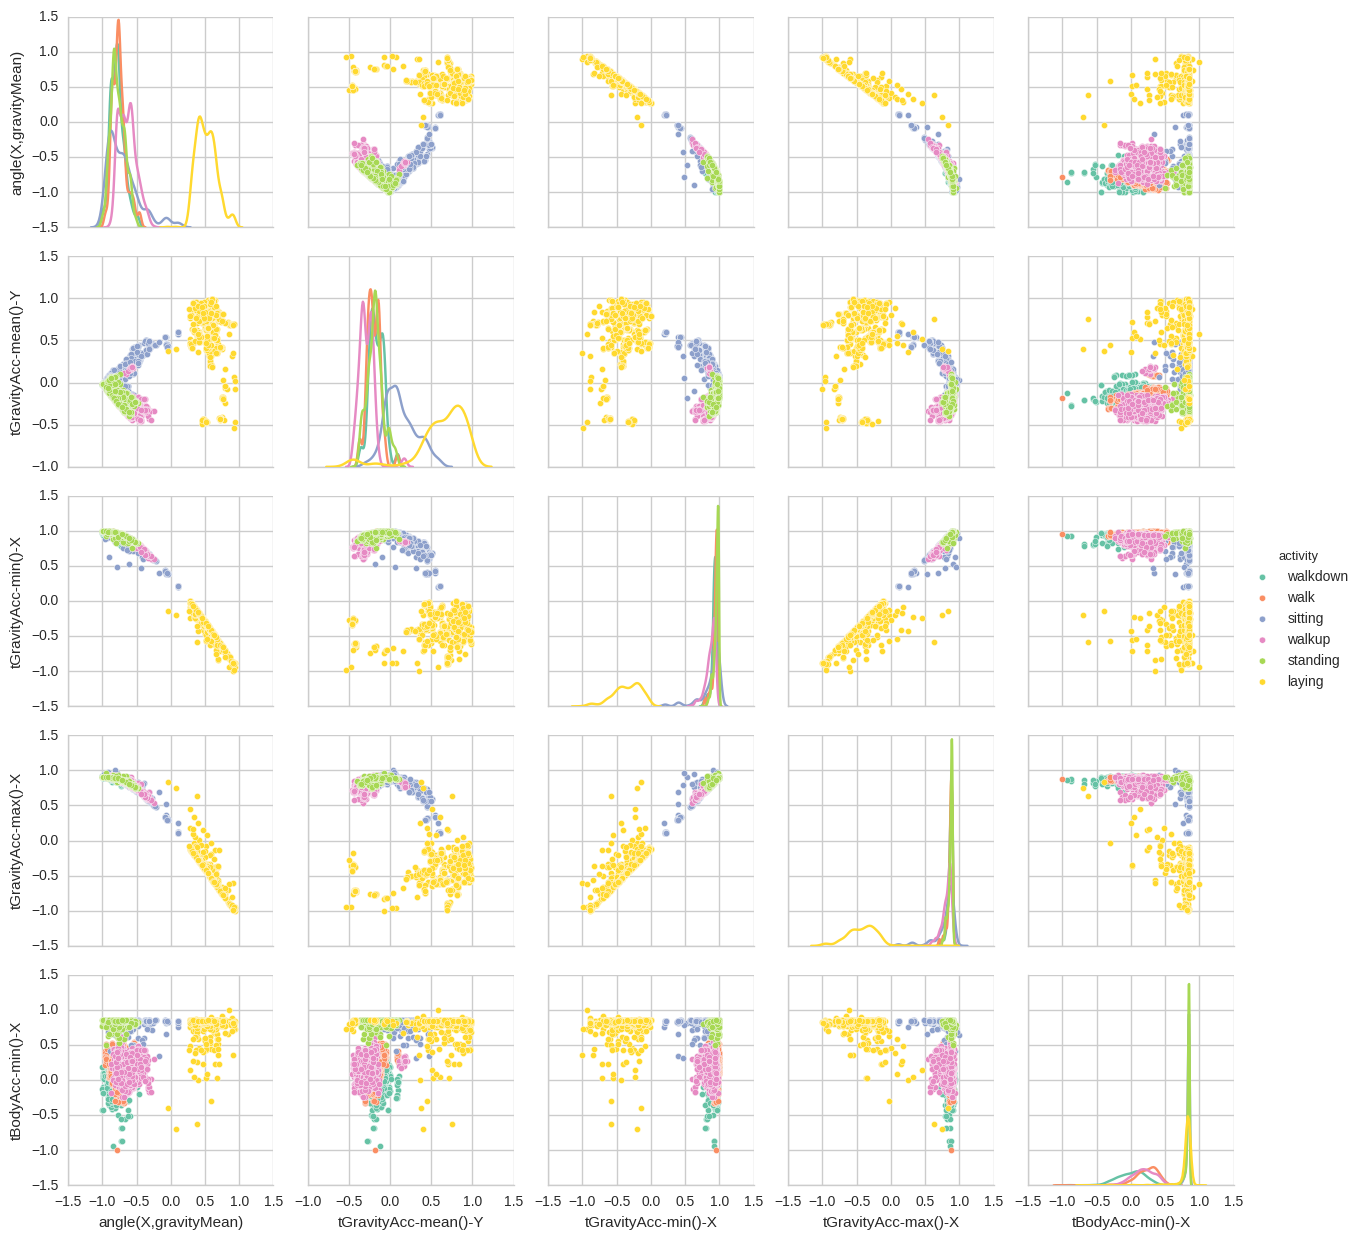

In [124]:
sns.plt.figure(figsize=(8,8))
sns.set_style('whitegrid')

sns.pairplot(data=train[[col for col in X.columns]+['activity']],
             hue='activity',
             palette='Set2',
             diag_kind='kde')